In [16]:
%matplotlib inline
import os
import warnings
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

from os.path import join, normpath
from datetime import datetime, timedelta


warnings.filterwarnings("ignore")
pd.options.display.max_columns = None


In [17]:
"""
    Distance estimation
"""
def LB_Keogh(s1, s2, r):
    LB_sum=0
    for ind,i in enumerate(s1):
        
        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        
        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2
    
    return np.sqrt(LB_sum)

In [18]:
"""
    Dynamic Time Warping similarity
"""

def DTWDistance(s1, s2):
    DTW={}
    
    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

In [19]:
"""
    Dynamic Time Warping similarity with window
"""
def DTWDistanceWithWindow(s1, s2, w):
    DTW={}
    
    w = max(w, abs(len(s1)-len(s2)))
    
    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
  
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
    return np.sqrt(DTW[len(s1)-1, len(s2)-1])


In [20]:
"""
    Set dirs
"""
cwd = os.getcwd()
data_dir = join(cwd, 'data')


In [21]:
"""
    Read data into dataframe
"""

file_in = os.path.join(data_dir, 'load_model_3months_better.csv')
data = pd.read_csv(file_in)
data.columns = [x.lower() for x in data.columns]
data.rename(columns={'index': 'timestamp'}, inplace=True)
data.drop_duplicates(inplace=True)
data.head()

timestamp     power         status  \
0  2017-03-03 14:47:15-08:00  0.000000         PlugIn   
1  2017-03-03 14:47:20-08:00  5.809206  ChargingStart   
2  2017-03-03 14:50:00-08:00  5.809206  ChargingStart   
3  2017-03-03 14:55:00-08:00  5.809206  ChargingStart   
4  2017-03-03 15:00:00-08:00  5.809206  ChargingStart   

                         unitid  
0  0100000100000046495017126501  
1  0100000100000046495017126501  
2  0100000100000046495017126501  
3  0100000100000046495017126501  
4  0100000100000046495017126501

In [22]:
"""
    Generate a dataset with units, timestamps, 
    and corresponded power consumption values,
    assuming that 0.0 is either unit pluged in or plugged out
"""

df = data.melt(id_vars=['unitid', 'timestamp', 'status']).loc[:, ['unitid', 'timestamp', 'value']]
df.rename(columns={'value': 'power'}, inplace=True)
df.drop_duplicates(inplace=True)
df.head()

unitid                  timestamp     power
0  0100000100000046495017126501  2017-03-03 14:47:15-08:00  0.000000
1  0100000100000046495017126501  2017-03-03 14:47:20-08:00  5.809206
2  0100000100000046495017126501  2017-03-03 14:50:00-08:00  5.809206
3  0100000100000046495017126501  2017-03-03 14:55:00-08:00  5.809206
4  0100000100000046495017126501  2017-03-03 15:00:00-08:00  5.809206

In [23]:
"""
    Cast to utc timestamp
"""
to_date = ['timestamp']
df[to_date] = df[to_date].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S'))
df.head()

unitid           timestamp     power
0  0100000100000046495017126501 2017-03-03 22:47:15  0.000000
1  0100000100000046495017126501 2017-03-03 22:47:20  5.809206
2  0100000100000046495017126501 2017-03-03 22:50:00  5.809206
3  0100000100000046495017126501 2017-03-03 22:55:00  5.809206
4  0100000100000046495017126501 2017-03-03 23:00:00  5.809206

In [24]:
"""
    Group data by 5-minute interval getting the average power
     - neccessary step since, neither initial nor final status
       falls into a 5-minute interval, but rather the exact timing
       of the event
     - the resulting step ends up being with slightly changed power
       values due to averaging plug in/out and charging statuses
     - this opearation is necessary, since every week there will be 
       equal number of 5-minute intervals, which allows for feasible
       creating of input features
"""
df = df.set_index('timestamp').groupby(['unitid', pd.TimeGrouper('5Min')])\
    .agg({'power': np.mean})\
    .reset_index()
df.head(50)

unitid           timestamp     power
0   0100000100000046495017126501 2017-03-03 22:45:00  2.904603
1   0100000100000046495017126501 2017-03-03 22:50:00  5.809206
2   0100000100000046495017126501 2017-03-03 22:55:00  5.809206
3   0100000100000046495017126501 2017-03-03 23:00:00  5.809206
4   0100000100000046495017126501 2017-03-03 23:05:00  5.809206
5   0100000100000046495017126501 2017-03-03 23:10:00  5.809206
6   0100000100000046495017126501 2017-03-03 23:15:00  5.809206
7   0100000100000046495017126501 2017-03-03 23:20:00  5.809206
8   0100000100000046495017126501 2017-03-03 23:25:00  5.809206
9   0100000100000046495017126501 2017-03-03 23:30:00  5.809206
10  0100000100000046495017126501 2017-03-03 23:35:00  5.809206
11  0100000100000046495017126501 2017-03-03 23:40:00  5.809206
12  0100000100000046495017126501 2017-03-03 23:45:00  5.809206
13  0100000100000046495017126501 2017-03-03 23:50:00  5.809206
14  0100000100000046495017126501 2017-03-03 23:55:00  5.809206
15  0100000100000046495017126501 2017-03-04 00:00:00  5.809206
16  0100000100000046495017126501 2017-03-04 00:05:00  5.809206
17  0100000100000046495017126501 2017-03-04 00:10:00  5.809206
18  0100000100000046495017126501 2017-03-04 00:15:00  5.809206
19  0100000100000046495017126501 2017-03-04 00:20:00  5.809206
20  0100000100000046495017126501 2017-03-04 00:25:00  5.809206
21  0100000100000046495017126501 2017-03-04 00:30:00  5.809206
22  0100000100000046495017126501 2017-03-04 00:35:00  5.809206
23  0100000100000046495017126501 2017-03-04 00:40:00  5.809206
24  0100000100000046495017126501 2017-03-04 00:45:00  5.809206
25  0100000100000046495017126501 2017-03-04 00:50:00  5.809206
26  0100000100000046495017126501 2017-03-04 00:55:00  5.809206
27  0100000100000046495017126501 2017-03-04 01:00:00  5.809206
28  0100000100000046495017126501 2017-03-04 01:05:00  5.809206
29  0100000100000046495017126501 2017-03-04 01:10:00  5.809206
30  0100000100000046495017126501 2017-03-04 01:15:00  5.809206
31  0100000100000046495017126501 2017-03-04 01:20:00  5.809206
32  0100000100000046495017126501 2017-03-04 01:25:00  5.809206
33  0100000100000046495017126501 2017-03-04 01:30:00  5.809206
34  0100000100000046495017126501 2017-03-04 01:35:00  5.809206
35  0100000100000046495017126501 2017-03-04 01:40:00  5.809206
36  0100000100000046495017126501 2017-03-04 01:45:00  5.809206
37  0100000100000046495017126501 2017-03-04 02:20:00  0.000000
38  0100000100000046495017126501 2017-03-04 20:20:00  3.136767
39  0100000100000046495017126501 2017-03-04 20:25:00  6.273534
40  0100000100000046495017126501 2017-03-04 20:30:00  6.273534
41  0100000100000046495017126501 2017-03-04 20:35:00  6.273534
42  0100000100000046495017126501 2017-03-04 20:40:00  6.273534
43  0100000100000046495017126501 2017-03-04 20:45:00  6.273534
44  0100000100000046495017126501 2017-03-04 20:50:00  6.273534
45  0100000100000046495017126501 2017-03-04 20:55:00  6.273534
46  0100000100000046495017126501 2017-03-04 21:00:00  6.273534
47  0100000100000046495017126501 2017-03-04 21:05:00  6.273534
48  0100000100000046495017126501 2017-03-04 21:10:00  6.273534
49  0100000100000046495017126501 2017-03-04 21:15:00  6.273534

In [25]:
"""
    Get the date range in order to work on weekly samples
"""
df.timestamp.describe()

count                 2315467
unique                  27306
top       2017-05-19 07:00:00
freq                      482
first     2017-02-24 03:20:00
last      2017-06-15 12:20:00
Name: timestamp, dtype: object

In [26]:
"""
    Get a weekly sample subset
     - start_date represents a starting day (Monday)
       with end_date calculated by adding 7 days
    
"""

start_date = '2017-05-01'
date_range = 7

start_str = start_date.split('-')
start = datetime(int(start_str[0]), int(start_str[1]), int(start_str[2]), 0, 0, 0)
end = start + timedelta(days=date_range)

# get a subset of the specified date range
df_s = df.loc[(df.timestamp >= start.strftime('%Y-%m-%d')) & (df.timestamp < end.strftime('%Y-%m-%d')), :]

# verify first and last day of the range
df_s.timestamp.describe()

count                  174084
unique                   1960
top       2017-05-05 07:00:00
freq                      455
first     2017-05-01 00:00:00
last      2017-05-07 23:55:00
Name: timestamp, dtype: object

In [27]:
df_s.head(30)

unitid           timestamp     power
1282  0100000100040062480017127802 2017-05-04 01:00:00  0.000000
1283  0100000100040062480017127802 2017-05-04 06:00:00  3.092232
1284  0100000100040062480017127802 2017-05-04 06:05:00  3.092232
1285  0100000100040062480017127802 2017-05-04 06:10:00  3.092232
1286  0100000100040062480017127802 2017-05-04 06:15:00  3.092232
1287  0100000100040062480017127802 2017-05-04 06:20:00  3.092232
1288  0100000100040062480017127802 2017-05-04 06:25:00  3.092232
1289  0100000100040062480017127802 2017-05-04 06:30:00  3.092232
1290  0100000100040062480017127802 2017-05-04 06:35:00  3.092232
1291  0100000100040062480017127802 2017-05-04 06:40:00  3.092232
1292  0100000100040062480017127802 2017-05-04 06:45:00  3.092232
1293  0100000100040062480017127802 2017-05-04 06:50:00  3.092232
1294  0100000100040062480017127802 2017-05-04 06:55:00  3.092232
1295  0100000100040062480017127802 2017-05-04 07:00:00  3.092232
1296  0100000100040062480017127802 2017-05-04 07:05:00  3.092232
1297  0100000100040062480017127802 2017-05-04 07:10:00  3.092232
1298  0100000100040062480017127802 2017-05-04 07:15:00  3.092232
1299  0100000100040062480017127802 2017-05-04 07:20:00  3.092232
1300  0100000100040062480017127802 2017-05-04 07:25:00  3.092232
1301  0100000100040062480017127802 2017-05-04 07:30:00  3.092232
1302  0100000100040062480017127802 2017-05-04 07:35:00  3.092232
1303  0100000100040062480017127802 2017-05-04 07:40:00  3.092232
1304  0100000100040062480017127802 2017-05-04 07:45:00  3.092232
1305  0100000100040062480017127802 2017-05-04 07:50:00  3.092232
1306  0100000100040062480017127802 2017-05-04 07:55:00  3.092232
1307  0100000100040062480017127802 2017-05-04 08:00:00  3.092232
1308  0100000100040062480017127802 2017-05-04 08:05:00  3.092232
1309  0100000100040062480017127802 2017-05-04 08:10:00  3.092232
1310  0100000100040062480017127802 2017-05-04 08:15:00  3.092232
1311  0100000100040062480017127802 2017-05-04 08:20:00  3.092232

In [28]:
"""
    Create a time-series in a form of dataframe 
    with 5-minute interval columns
"""
df_ts = df_s.pivot_table(index='unitid', columns='timestamp', values='power').fillna(0.0)
df_ts.columns = df_ts.columns.get_level_values(0)
df_ts.head(30)

timestamp                     2017-05-01 00:00:00  2017-05-01 00:05:00  \
unitid                                                                   
0100000100040062480017127802             0.000000             0.000000   
0100000100040063725017127802             0.000000             0.000000   
0100000100040064488017127802             0.000000             0.000000   
0100000100050053995017127902             0.000000             0.000000   
0100000100050055560017127902             0.000000             0.000000   
0100000100050056133017127902             0.000000             0.000000   
0100000100050056770017127902             0.000000             0.000000   
0100000100050058535017127902             0.000000             0.000000   
0100000100050059369017127902             0.000000             0.000000   
0100000100050059946017127902             0.000000             0.000000   
0100000100050060777017127902             0.000000             0.000000   
0100000100050061818017127902             0.000000             0.000000   
0100000100050062130017127902             0.000000             0.000000   
0100000100050062822017127902             0.000000             0.000000   
0100000100050064482017127902             0.000000             0.000000   
0100000100070053861017128202             0.000000             0.000000   
0100000100070054565017128202             0.000000             0.000000   
0100000100070056051017128202             0.000000             0.000000   
0100000100080041407017129602             0.000000             0.000000   
0100000100080042179017129602             0.000000             0.000000   
0100000100080044024017129602             0.000000             0.000000   
0100000100080044845017129602             0.000000             0.000000   
0100000100080046139017129602             0.000000             0.000000   
0100000100080046818017129602             0.000000             0.000000   
0100000100080047998017129602             0.000000             0.000000   
0100000100080048374017129602             0.000000             0.000000   
0100000100080049037017129602             0.000000             0.000000   
0100000100080050065017129602             0.000000             0.000000   
0100000100080050982017129602             0.000000             0.000000   
0100000100080052838017129602             7.337102             7.337102   

timestamp                     2017-05-01 00:10:00  2017-05-01 00:15:00  \
unitid                                                                   
0100000100040062480017127802             0.000000             0.000000   
0100000100040063725017127802             0.000000             0.000000   
0100000100040064488017127802             0.000000             0.000000   
0100000100050053995017127902             0.000000             0.000000   
0100000100050055560017127902             0.000000             0.000000   
0100000100050056133017127902             0.000000             0.000000   
0100000100050056770017127902             0.000000             0.000000   
0100000100050058535017127902             0.000000             0.000000   
0100000100050059369017127902             0.000000             0.000000   
0100000100050059946017127902             0.000000             0.000000   
0100000100050060777017127902             0.000000             0.000000   
0100000100050061818017127902             0.000000             0.000000   
0100000100050062130017127902             0.000000             0.000000   
0100000100050062822017127902             0.000000             0.000000   
0100000100050064482017127902             0.000000             0.000000   
0100000100070053861017128202             0.000000             0.000000   
0100000100070054565017128202             0.000000             0.000000   
0100000100070056051017128202             0.000000             0.000000   
0100000100080041407017129602             0.000000             0.000000   
0100000100080042179017129602             0.000000             0.000000   
010

In [29]:
"""
    Create zero padded matrix with all possible
    5-minute intervals between start and end dates,
    except those found in the actual time series
    from the real data
"""
from datetime import datetime, timedelta


seconds = (end - start).total_seconds()
step = timedelta(minutes=5)

columns = np.setdiff1d(
    [(start + timedelta(seconds=x)).strftime('%Y-%m-%d %H:%M:%S') for x in range(0, int(seconds), int(step.total_seconds()))],
    [x.strftime('%Y-%m-%d %H:%M:%S') for x in df_ts.columns])

rows = df_s.unitid.unique()
power = pd.DataFrame(
    np.zeros(shape=(len(rows), len(columns))), 
    index=rows, 
    columns=columns
)
power.head(20)

2017-05-02 12:00:00  2017-05-02 12:05:00  \
0100000100040062480017127802                  0.0                  0.0   
0100000100040063725017127802                  0.0                  0.0   
0100000100040064488017127802                  0.0                  0.0   
0100000100050053995017127902                  0.0                  0.0   
0100000100050055560017127902                  0.0                  0.0   
0100000100050056133017127902                  0.0                  0.0   
0100000100050056770017127902                  0.0                  0.0   
0100000100050058535017127902                  0.0                  0.0   
0100000100050059369017127902                  0.0                  0.0   
0100000100050059946017127902                  0.0                  0.0   
0100000100050060777017127902                  0.0                  0.0   
0100000100050061818017127902                  0.0                  0.0   
0100000100050062130017127902                  0.0                  0.0   
0100000100050062822017127902                  0.0                  0.0   
0100000100050064482017127902                  0.0                  0.0   
0100000100070053861017128202                  0.0                  0.0   
0100000100070054565017128202                  0.0                  0.0   
0100000100070056051017128202                  0.0                  0.0   
0100000100080041407017129602                  0.0                  0.0   
0100000100080042179017129602                  0.0                  0.0   

                              2017-05-02 12:10:00  2017-05-02 12:15:00  \
0100000100040062480017127802                  0.0                  0.0   
0100000100040063725017127802                  0.0                  0.0   
0100000100040064488017127802                  0.0                  0.0   
0100000100050053995017127902                  0.0                  0.0   
0100000100050055560017127902                  0.0                  0.0   
0100000100050056133017127902                  0.0                  0.0   
0100000100050056770017127902                  0.0                  0.0   
0100000100050058535017127902                  0.0                  0.0   
0100000100050059369017127902                  0.0                  0.0   
0100000100050059946017127902                  0.0                  0.0   
0100000100050060777017127902                  0.0                  0.0   
0100000100050061818017127902                  0.0                  0.0   
0100000100050062130017127902                  0.0                  0.0   
0100000100050062822017127902                  0.0                  0.0   
0100000100050064482017127902                  0.0                  0.0   
0100000100070053861017128202                  0.0                  0.0   
0100000100070054565017128202                  0.0                  0.0   
0100000100070056051017128202                  0.0                  0.0   
0100000100080041407017129602                  0.0                  0.0   
0100000100080042179017129602                  0.0                  0.0   

                              2017-05-02 12:20:00  2017-05-02 12:25:00  \
0100000100040062480017127802                  0.0                  0.0   
0100000100040063725017127802                  0.0                  0.0   
0100000100040064488017127802                  0.0                  0.0   
0100000100050053995017127902                  0.0                  0.0   
0100000100050055560017127902                  0.0                  0.0   
0100000100050056133017127902                  0.0                  0.0   
0100000100050056770017127902                  0.0                  0.0   
0100000100050058535017127902                  0.0                  0.0   
0100000100050059369017127902                  0.0                  0.0   
0100000100050059946017127902                  0.0                  0.0   
0100000100050060777017127902                  0.0                  0.0   
0100000100050061818017127902    

In [30]:
"""
    Merge the actual data with zero padded matrix,
    in order to get the matrix of a fixed size
"""
df_ts = power.join(df_ts)
df_ts.columns = [pd.to_datetime(x) for x in df_ts.columns]
df_ts.sort_index(axis=1, inplace=True)
df_ts.head(20)

2017-05-01 00:00:00  2017-05-01 00:05:00  \
0100000100040062480017127802                  0.0                  0.0   
0100000100040063725017127802                  0.0                  0.0   
0100000100040064488017127802                  0.0                  0.0   
0100000100050053995017127902                  0.0                  0.0   
0100000100050055560017127902                  0.0                  0.0   
0100000100050056133017127902                  0.0                  0.0   
0100000100050056770017127902                  0.0                  0.0   
0100000100050058535017127902                  0.0                  0.0   
0100000100050059369017127902                  0.0                  0.0   
0100000100050059946017127902                  0.0                  0.0   
0100000100050060777017127902                  0.0                  0.0   
0100000100050061818017127902                  0.0                  0.0   
0100000100050062130017127902                  0.0                  0.0   
0100000100050062822017127902                  0.0                  0.0   
0100000100050064482017127902                  0.0                  0.0   
0100000100070053861017128202                  0.0                  0.0   
0100000100070054565017128202                  0.0                  0.0   
0100000100070056051017128202                  0.0                  0.0   
0100000100080041407017129602                  0.0                  0.0   
0100000100080042179017129602                  0.0                  0.0   

                              2017-05-01 00:10:00  2017-05-01 00:15:00  \
0100000100040062480017127802                  0.0                  0.0   
0100000100040063725017127802                  0.0                  0.0   
0100000100040064488017127802                  0.0                  0.0   
0100000100050053995017127902                  0.0                  0.0   
0100000100050055560017127902                  0.0                  0.0   
0100000100050056133017127902                  0.0                  0.0   
0100000100050056770017127902                  0.0                  0.0   
0100000100050058535017127902                  0.0                  0.0   
0100000100050059369017127902                  0.0                  0.0   
0100000100050059946017127902                  0.0                  0.0   
0100000100050060777017127902                  0.0                  0.0   
0100000100050061818017127902                  0.0                  0.0   
0100000100050062130017127902                  0.0                  0.0   
0100000100050062822017127902                  0.0                  0.0   
0100000100050064482017127902                  0.0                  0.0   
0100000100070053861017128202                  0.0                  0.0   
0100000100070054565017128202                  0.0                  0.0   
0100000100070056051017128202                  0.0                  0.0   
0100000100080041407017129602                  0.0                  0.0   
0100000100080042179017129602                  0.0                  0.0   

                              2017-05-01 00:20:00  2017-05-01 00:25:00  \
0100000100040062480017127802             0.000000             0.000000   
0100000100040063725017127802             0.000000             0.000000   
0100000100040064488017127802             0.000000             0.000000   
0100000100050053995017127902             0.870326             3.481303   
0100000100050055560017127902             0.000000             0.000000   
0100000100050056133017127902             0.000000             0.000000   
0100000100050056770017127902             0.000000             0.000000   
0100000100050058535017127902             0.000000             0.000000   
0100000100050059369017127902             0.000000             0.000000   
0100000100050059946017127902             0.000000             0.000000   
0100000100050060777017127902             0.000000             0.000000   
0100000100050061818017127902    

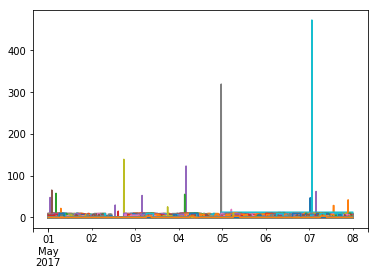

In [31]:
"""
    Plot time-series of consumed power,
    in order to visualy check obvious outliers
"""
df_ts.T.plot(legend=False)

In [32]:
"""
    Generate descriptive statistics for each 5-minute interval
"""
des = df_ts.describe()

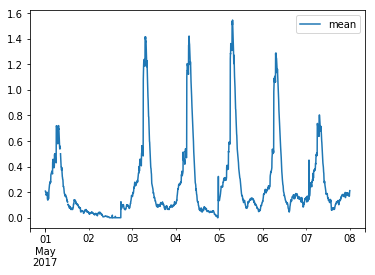

In [33]:
"""
    Plot average values of power consumption
     - plot reveals that the time series might be thought 
       as stationary and no transformation is required
"""
des[des.index=='mean'].T.plot()